# Tiền Xử Lý Dữ Liệu Email

Notebook này thực hiện:
1. Trích xuất và xử lý email từ 5 nguồn dữ liệu khác nhau
2. Làm sạch dữ liệu (loại bỏ header, HTML, metadata)
3. Gộp tất cả thành một dataset duy nhất
4. Loại bỏ trùng lặp và xáo trộn thứ tự
5. Lưu ra CSV để sử dụng trong các bước tiếp theo

## Các nguồn dữ liệu:
1. **fradulent_emails.txt** - Phishing emails
2. **ham_zipped/main_ham** - Benign emails
3. **spam_zipped/main_spam** - Phishing emails
4. **emails-enron-legal-mails.mbox** - Benign emails
5. **emails-phishing-nazario.mbox** - Phishing emails
6. **Nigerian_Fraud.csv** - Phishing emails (CSV format)


In [ ]:
# IMPORTS
import os
import re
import random
import email
import mailbox
import warnings
import pandas as pd
from email.policy import default
from bs4 import BeautifulSoup
from tqdm import tqdm

warnings.filterwarnings('ignore')

print("✓ Tất cả thư viện đã được import thành công!")


✓ Tất cả thư viện đã được import thành công!


In [ ]:
# SETUP - Thiết lập thư mục làm việc

root_dir = "D:\\BiiDenn\\PTITHCM\\Mon hoc\\HK9(2025-2026)\\DATN\\Graduation-Project"
os.chdir(root_dir)
print(f"Working directory: {os.getcwd()}")

Working directory: D:\BiiDenn\PTITHCM\Mon hoc\HK9(2025-2026)\DATN\DL-in-detecting-email-with-fake-content


## 1. Trích xuất Email Phishing từ `fradulent_emails.txt`


In [3]:
# Đọc file fradulent_emails.txt
with open("./data/raw/fradulent_emails.txt", encoding='latin1') as f:
    text = f.read()

# Tách từng email dựa trên mẫu bắt đầu "From r"
messages = re.split(r'From r\s+', text)

# Mẫu nhận diện phần header của email
header_pattern = re.compile(r'(.*?)\n\n', re.DOTALL)

phishing_messages_1 = []

for message in messages:
    if not message.strip():
        continue
    
    # Tách phần nội dung chính, bỏ qua header
    header_match = header_pattern.match(message)
    if header_match:
        body = message[header_match.end():].strip()
    else:
        body = message.strip()
    
    phishing_messages_1.append(body)

print("=" * 70)
print("Kết quả trích trích xuất từ fradulent_emails.txt")
print("=" * 70)
print(f"Tổng số email đã trích xuất: {len(phishing_messages_1)}")
print(f"\nMẫu email ngẫu nhiên:")
print("#" * 100)
print(random.choice(phishing_messages_1))


Kết quả trích trích xuất từ fradulent_emails.txt
Tổng số email đã trích xuất: 3976

Mẫu email ngẫu nhiên:
####################################################################################################
From=3A Mrs Farah al-Hashemi
Address=3A Chiang Rai hospital
31-12 Chiang Rai - Lampoon Rd=2C
=2CChiang Rai Thailand

Dearest Beloved=2C

Thank you for the attention beeing given to  my mail=2EI am Mrs=2EFarah al-Hashemi=2C The wife of iraq military finance corps Chief=2C who was incharge of the payment of the military salary during his life service
time =2E I am 58 years old=2C i am now receiving treatment in the hospital=2E It's quite obvious that I won't live Longer according to my doctor as i am sufering from my kidney transplant illness=2Cthis is because my illness has gotten to a very bad stage=2E

My late husband died from the British and American attacks over my country =2Cand during the period of our marriage we had two male children Musa and Idris=2EAfter the death of my hu

## 2. Xử lý Email Benign từ `ham_zipped/main_ham`


In [4]:
# Hàm trích xuất body từ email file
def extract_email_body(file_path):
    """Trích xuất body từ một file email"""
    try:
        # Đọc nội dung email ở dạng nhị phân
        with open(file_path, 'rb') as file:
            binary_content = file.read()

        # Cố gắng giải mã email bằng nhiều bộ mã khác nhau
        email_content = None
        encodings = ['utf-8', 'latin1', 'ascii']
        for enc in encodings:
            try:
                email_content = binary_content.decode(enc)
                break
            except UnicodeDecodeError:
                continue

        if email_content is None:
            email_content = binary_content.decode('latin1', errors='replace')

        # Phân tích cấu trúc email để lấy phần nội dung chính (body)
        msg = email.message_from_string(email_content, policy=default)
        body = None

        if msg.is_multipart():
            for part in msg.walk():
                content_type = part.get_content_type()
                content_disposition = str(part.get("Content-Disposition"))
                # Bỏ qua file đính kèm, chỉ lấy phần văn bản thuần (text/plain)
                if "attachment" not in content_disposition and content_type == "text/plain":
                    body = part.get_payload(decode=True).decode(errors='replace')
                    break
        else:
            body = msg.get_payload(decode=True).decode(errors='replace')

        return body
    except Exception as e:
        return None

# Trích xuất email từ thư mục ham_zipped/main_ham
directory_ham = "./data/raw/ham_zipped/main_ham"
ham_messages = []

print("Đang trích xuất email từ ham_zipped/main_ham...")
for filename in tqdm(os.listdir(directory_ham), desc="Processing ham emails"):
    file_path = os.path.join(directory_ham, filename)
    body = extract_email_body(file_path)
    if body:
        ham_messages.append(body)

print("=" * 70)
print("Kết quả trích xuất từ ham_zipped/main_ham")
print("=" * 70)
print(f"Tổng số email benign đã trích xuất: {len(ham_messages)}")
print(f"\nMẫu email ngẫu nhiên:")
print("#" * 100)
print(random.choice(ham_messages))


Đang trích xuất email từ ham_zipped/main_ham...


Processing ham emails: 100%|██████████| 6951/6951 [00:04<00:00, 1588.12it/s]

Kết quả trích xuất từ ham_zipped/main_ham
Tổng số email benign đã trích xuất: 6947

Mẫu email ngẫu nhiên:
####################################################################################################
Today's Headlines from The Register
-----------------------------------

    To unsubscribe from this daily news update, see the instructions at
    the end of this message.


  --------ADVERTISEMENT------------------------------------------------

  WIN tickets to a FORMULA ONE EUROPEAN GRAND PRIX!

  Neverfail Group plc, business continuity software expert, sponsors Rubens
  Barrichello driver of the Ferrari F1 team. Click here to find out more and
  win tickets: www.neverfailgroup.com/f1theregister.html.

  For every new customer that buys Neverfail(tm) products between the
  July-September 2002 Grand Prix season, Neverfail Group plc will grant 2
  tickets to a Grand Prix hospitality event with us next 2003 season.

  --------------------------------------------------------------

In [5]:
# Trích xuất email từ thư mục spam_zipped/main_spam
directory_spam = "./data/raw/spam_zipped/main_spam"
phishing_messages_2 = []

print("Đang trích xuất email từ spam_zipped/main_spam...")
for filename in tqdm(os.listdir(directory_spam), desc="Processing spam emails"):
    file_path = os.path.join(directory_spam, filename)
    body = extract_email_body(file_path)
    if body:
        phishing_messages_2.append(body)

print("=" * 70)
print("Kết quả trích xuất spam_zipped/main_spam")
print("=" * 70)
print(f"Tổng số email phishing đã trích xuất: {len(phishing_messages_2)}")


Đang trích xuất email từ spam_zipped/main_spam...


Processing spam emails: 100%|██████████| 2398/2398 [00:03<00:00, 642.80it/s] 

Kết quả trích xuất spam_zipped/main_spam
Tổng số email phishing đã trích xuất: 2293


In [6]:
# Làm sạch nội dung HTML trong email Spam
phishing_messages_3 = []
for ph_message in tqdm(phishing_messages_2, desc="Cleaning HTML"):
    soup = BeautifulSoup(ph_message, 'html.parser')
    body = soup.get_text(separator='\n')
    phishing_messages_3.append(body.strip())

print("=" * 70)
print("Sau khi làm sạch")
print("=" * 70)
print(f"Tổng số email: {len(phishing_messages_3)}")
print(f"\nMẫu email ngẫu nhiên:")
print("#" * 100)
print(random.choice(phishing_messages_3))


Cleaning HTML: 100%|██████████| 2293/2293 [00:03<00:00, 756.29it/s]

Sau khi làm sạch
Tổng số email: 2293

Mẫu email ngẫu nhiên:
####################################################################################################
GET FREE ACCESS TO XXX PORN!
INSTANT ACCESS... 100% FREE HARDCORE
Note: If you would would like to be removed from our list, please reply to this email with the word REMOVE as the subject


hxvwnj3q


## 4. Xử lý Email Benign từ `emails-enron-legal-mails.mbox`


In [7]:
# Trích xuất email từ file mbox
legal_emails_file = "./data/raw/emails-enron-legal-mails.mbox"
legal_emails = []
mbox = mailbox.mbox(legal_emails_file)

print("Đang trích xuất email từ emails-enron-legal-mails.mbox...")
for msg in tqdm(mbox, desc="Processing mbox emails"):
    body = None
    if msg.is_multipart():
        for part in msg.walk():
            if "attachment" not in str(part.get("Content-Disposition")) and part.get_content_type() == "text/plain":
                body = part.get_payload(decode=True).decode('utf-8', errors='replace')
                break
    else:
        body = msg.get_payload(decode=True).decode('utf-8', errors='replace')
    if body:
        legal_emails.append(body)

print("=" * 70)
print("Kết quả trích xuất từ emails-enron-legal-mails.mbox")
print("=" * 70)
print(f"Tổng số email benign đã trích xuất: {len(legal_emails)}")


Đang trích xuất email từ emails-enron-legal-mails.mbox...


Processing mbox emails: 100%|██████████| 4279/4279 [00:00<00:00, 8858.43it/s]

Kết quả trích xuất từ emails-enron-legal-mails.mbox
Tổng số email benign đã trích xuất: 4279


In [8]:
# Làm sạch phần header, metadata trong email Benign
legal_emails_cleaned = []
for email_text in tqdm(legal_emails, desc="Cleaning headers"):
    # Loại bỏ forwarded/replied metadata
    email_text = re.sub(r'(--+ Forwarded by .* --+|--+ Original Message --+|--+ Reply Separator --+)', '', email_text, flags=re.IGNORECASE)
    # Loại bỏ email headers (To, From, Cc, etc.)
    email_text = re.sub(r'(^|\n)(From|To|Cc|Subject|Bcc):.*(\n|$)', '', email_text, flags=re.IGNORECASE)
    # Loại bỏ metadata xuất hiện sau body
    email_text = re.sub(r'(\n\n.*(On .* wrote:|Sent from my .*|From: .*|Subject: .*|\[Quoted text hidden\]))', '', email_text, flags=re.IGNORECASE)
    email_text = email_text.strip()
    legal_emails_cleaned.append(email_text)

print("=" * 70)
print("Sau khi làm sạch headers")
print("=" * 70)
print(f"Tổng số email: {len(legal_emails_cleaned)}")
print(f"\nMẫu email ngẫu nhiên:")
print("-" * 100)
for message in random.sample(legal_emails_cleaned, 2):
    print(message, '\n\n', '#' * 100)


Cleaning headers: 100%|██████████| 4279/4279 [00:00<00:00, 18152.33it/s]

Sau khi làm sạch headers
Tổng số email: 4279

Mẫu email ngẫu nhiên:
----------------------------------------------------------------------------------------------------
---------------------- Forwarded by Mary Hain/HOU/ECT on 02/23/2001 05:18 PM 
---------------------------
   
	Enron Capital & Trade Resources Corp.
	
	From:  "Jeffrey Watkiss" <dwatkiss@bracepatt.com>                           
02/23/2001 06:23 AM
	
<Joe.Hartsoe@enron.com>, <Mary.Hain@enron.com>, <Richard.Sanders@enron.com>, 
<steve.c.hall@enron.com>Subject: Re: Hendricks v. Dynegy


I have recommended this before and continue to believe that it should (and 
could successfully) be pursued.  Could someone forward the Hendricks 
pleading?  On instruction from Richard, I would be happy to start the 
lobbying campaign at FERC (and possibly the SG's office as well) to secure 
such a supportive pleading.


>>> <Mary.Hain@enron.com> 02/22/01 05:54PM >>>
Today, I worked with Robin Gibbs and Jeff Alexander on an Enron pleading 

## 5. Trích xuất Email Phishing từ `emails-phishing-nazario.mbox`


In [9]:
# Trích xuất email từ file mbox phishing
phishing_nazario_file_path = "./data/raw/emails-phishing-nazario.mbox"
phishing_nazario_messages = []

mbox = mailbox.mbox(phishing_nazario_file_path)
print("Đang trích xuất email từ emails-phishing-nazario.mbox...")
for message in tqdm(mbox, desc="Processing phishing mbox"):
    phishing_nazario_messages.append(message)

print("=" * 70)
print("Kết quả trích xuất từ emails-phishing-nazario.mbox")
print("=" * 70)
print(f"Tổng số email phishing: {len(phishing_nazario_messages)}")


Đang trích xuất email từ emails-phishing-nazario.mbox...


Processing phishing mbox: 100%|██████████| 2279/2279 [00:00<00:00, 2627.21it/s]

Kết quả trích xuất từ emails-phishing-nazario.mbox
Tổng số email phishing: 2279


In [10]:
# Loại bỏ các email lỗi Unicode
cleaned_phishing_nazario_messages = []
for message in tqdm(phishing_nazario_messages, desc="Filtering Unicode errors"):
    try:
        # Decode và Encode tin nhắn để xử lý các ký tự Unicode
        message_str = message.as_string()
        message_str.encode('utf-8')
        cleaned_phishing_nazario_messages.append(message)
    except UnicodeEncodeError:
        continue

print("=" * 70)
print("Sau khi loại bỏ lỗi Unicode")
print("=" * 70)
print(f"Đã loại bỏ: {len(phishing_nazario_messages) - len(cleaned_phishing_nazario_messages)} email")
print(f"Số email còn lại: {len(cleaned_phishing_nazario_messages)}")


Filtering Unicode errors: 100%|██████████| 2279/2279 [00:01<00:00, 1396.45it/s]

Sau khi loại bỏ lỗi Unicode
Đã loại bỏ: 141 email
Số email còn lại: 2138


In [11]:
# Trích xuất nội dung văn bản từ các email HTML Nazario
cleaned_phishing_nazario_messages_text = []
for message in tqdm(cleaned_phishing_nazario_messages, desc="Extracting text from HTML"):
    if isinstance(message, email.message.Message):
        payload = message.get_payload()
        html_content = ''
        if isinstance(payload, str):
            html_content = payload
        elif isinstance(payload, list):
            for part in payload:
                if isinstance(part, str):
                    html_content += part
                elif isinstance(part, email.message.Message):
                    sub_payload = part.get_payload()
                    if isinstance(sub_payload, str):
                        html_content += sub_payload
        soup = BeautifulSoup(html_content, 'html.parser')
        text = soup.get_text(separator='\n')
        if '*******' in text:
            text = text.split('*******')[0]
        cleaned_phishing_nazario_messages_text.append(text)

print("=" * 70)
print("Sau khi trích xuất text từ HTML")
print("=" * 70)
print(f"Tổng số email: {len(cleaned_phishing_nazario_messages_text)}")


Extracting text from HTML: 100%|██████████| 2138/2138 [00:06<00:00, 347.62it/s]

Sau khi trích xuất text từ HTML
Tổng số email: 2138


In [12]:
# Loại bỏ các từ quá dài (hơn 25 ký tự)
cleaned_phishing_nazario_messages_text_1 = []
for message in tqdm(cleaned_phishing_nazario_messages_text, desc="Removing long words"):
    words = message.split()
    cleaned_words = [word for word in words if len(word) <= 25]
    cleaned_message = ' '.join(cleaned_words)
    cleaned_phishing_nazario_messages_text_1.append(cleaned_message)

print(f"Đã xử lý: {len(cleaned_phishing_nazario_messages_text_1)} email")


Removing long words:   0%|          | 0/2138 [00:00<?, ?it/s]

Removing long words: 100%|██████████| 2138/2138 [00:00<00:00, 29619.79it/s]

Đã xử lý: 2138 email


## 6. Tạo DataFrame và Gộp Dữ liệu từ 5 Nguồn


In [13]:
# Tạo DataFrame cho email Benign
all_ham_messages = ham_messages + legal_emails_cleaned
ham_df = pd.DataFrame({'phishing': [0]*len(all_ham_messages), 'text': all_ham_messages})

print("=" * 70)
print("DataFrame Benign")
print("=" * 70)
print(f"Tổng số email benign: {len(ham_df)}")
print(f"  - Từ ham_zipped/main_ham: {len(ham_messages)}")
print(f"  - Từ emails-enron-legal-mails.mbox: {len(legal_emails_cleaned)}")


DataFrame Benign
Tổng số email benign: 11226
  - Từ ham_zipped/main_ham: 6947
  - Từ emails-enron-legal-mails.mbox: 4279


In [14]:
# Tạo DataFrame cho email Phishing
all_phishing_data = phishing_messages_1 + phishing_messages_3 + cleaned_phishing_nazario_messages_text_1
phishing_df = pd.DataFrame({'phishing': [1]*len(all_phishing_data), 'text': all_phishing_data})

print("=" * 70)
print("DataFrame Phishing")
print("=" * 70)
print(f"Tổng số email phishing: {len(phishing_df)}")
print(f"  - Từ fradulent_emails.txt: {len(phishing_messages_1)}")
print(f"  - Từ spam_zipped/main_spam: {len(phishing_messages_3)}")
print(f"  - Từ emails-phishing-nazario.mbox: {len(cleaned_phishing_nazario_messages_text_1)}")


DataFrame Phishing
Tổng số email phishing: 8407
  - Từ fradulent_emails.txt: 3976
  - Từ spam_zipped/main_spam: 2293
  - Từ emails-phishing-nazario.mbox: 2138


In [15]:
# Gộp hai DataFrame thành một
data = pd.concat([phishing_df, ham_df], axis=0)

# Đổi tên cột cho phù hợp
data = data.rename(columns={'phishing': 'label', 'text': 'text'})

print("=" * 70)
print("Dataset sau khi gộp")
print("=" * 70)
print(f"Tổng số dòng: {data.shape[0]}")
print(f"Tổng số cột: {data.shape[1]}")
print(f"\nPhân phối label:")
print(data['label'].value_counts())
print(f"\nTỷ lệ:")
print(data['label'].value_counts(normalize=True).map("{:.2%}".format))


Dataset sau khi gộp
Tổng số dòng: 19633
Tổng số cột: 2

Phân phối label:
label
0    11226
1     8407
Name: count, dtype: int64

Tỷ lệ:
label
0    57.18%
1    42.82%
Name: proportion, dtype: object


In [16]:
# Xáo trộn thứ tự dữ liệu để tránh bias
shuffled_df = data.sample(frac=1, random_state=42).reset_index(drop=True)

print("=" * 70)
print("Sau khi xáo trộn")
print("=" * 70)
print(f"Tổng số dòng: {shuffled_df.shape[0]}")
print(f"Phân phối label:")
print(shuffled_df['label'].value_counts())


Sau khi xáo trộn
Tổng số dòng: 19633
Phân phối label:
label
0    11226
1     8407
Name: count, dtype: int64


In [17]:
# Kiểm tra dữ liệu thiếu
print("=" * 70)
print("Kiểm tra dữ liệu thiếu")
print("=" * 70)
missing_data = shuffled_df.isna().sum()
print(missing_data)
print(f"\nTổng số giá trị thiếu: {missing_data.sum()}")


Kiểm tra dữ liệu thiếu
label    0
text     0
dtype: int64

Tổng số giá trị thiếu: 0


In [18]:
# Kiểm tra duplicates
print("=" * 70)
print("Kiểm tra duplicates")
print("=" * 70)
total_duplicates = shuffled_df.duplicated().sum()
duplicated_phishing = shuffled_df[shuffled_df['label']==1].duplicated().sum()
duplicated_ham = shuffled_df[shuffled_df['label']==0].duplicated().sum()

print(f"Tổng số duplicates: {total_duplicates}")
print(f"  - Phishing duplicates: {duplicated_phishing}")
print(f"  - Ham duplicates: {duplicated_ham}")


Kiểm tra duplicates
Tổng số duplicates: 4674
  - Phishing duplicates: 1977
  - Ham duplicates: 2697


In [19]:
# Loại bỏ duplicates
shuffled_df = shuffled_df.drop_duplicates().reset_index(drop=True)

print("=" * 70)
print("Sau khi loại bỏ duplicates")
print("=" * 70)
print(f"Tổng số dòng: {shuffled_df.shape[0]}")
print(f"Phân phối label:")
print(shuffled_df['label'].value_counts())
print(f"\nTỷ lệ:")
print(shuffled_df['label'].value_counts(normalize=True).map("{:.2%}".format))


Sau khi loại bỏ duplicates
Tổng số dòng: 14959
Phân phối label:
label
0    8529
1    6430
Name: count, dtype: int64

Tỷ lệ:
label
0    57.02%
1    42.98%
Name: proportion, dtype: object


In [20]:
# Làm sạch text: loại bỏ nhiều dòng trống, khoảng trắng thừa
print("Đang làm sạch text...")
for i in tqdm(range(len(shuffled_df)), desc="Cleaning text"):
    text = shuffled_df.loc[i, 'text']
    
    if isinstance(text, str):
        # Thay nhiều dòng trống bằng 1 khoảng trắng
        text = re.sub(r'\n+', ' ', text)
        # Thay nhiều space/tab bằng 1 khoảng trắng
        text = re.sub(r'[ \t]+', ' ', text)
        # Xóa khoảng trắng ở đầu/cuối
        text = text.strip()
        # Dọn thêm nếu còn thừa
        text = re.sub(r'\s+', ' ', text).strip()
        
        shuffled_df.loc[i, 'text'] = text

print("✓ Hoàn thành làm sạch text!")


Đang làm sạch text...


Cleaning text: 100%|██████████| 14959/14959 [00:05<00:00, 2736.01it/s]

✓ Hoàn thành làm sạch text!


In [21]:
# Lưu file processed_1.csv
output_file = './data/processed/processed_1.csv'
os.makedirs(os.path.dirname(output_file), exist_ok=True)
shuffled_df.to_csv(output_file, index=False, escapechar='\\')

print("=" * 70)
print("Đã lưu file")
print("=" * 70)
print(f"✓ {output_file}")
print(f"  - Số dòng: {len(shuffled_df)}")
print(f"  - Số cột: {shuffled_df.shape[1]}")


Đã lưu file
✓ ./data/processed/processed_1.csv
  - Số dòng: 14959
  - Số cột: 2


## 7. Xử lý Dataset `Nigerian_Fraud.csv`


In [22]:
# Load dataset Nigerian_Fraud.csv
df = pd.read_csv('./data/raw/Nigerian_Fraud.csv')

print("=" * 70)
print("Thông tin dataset Nigerian_Fraud.csv")
print("=" * 70)
print(f"Tổng số dòng: {df.shape[0]}")
print(f"Tổng số cột: {df.shape[1]}")
print(f"\nCác cột: {df.columns.tolist()}")
print(f"\nPhân phối label:")
print(df['label'].value_counts())


Thông tin dataset Nigerian_Fraud.csv
Tổng số dòng: 3332
Tổng số cột: 7

Các cột: ['sender', 'receiver', 'date', 'subject', 'body', 'urls', 'label']

Phân phối label:
label
1    3332
Name: count, dtype: int64


In [23]:
# Chọn các cột cần thiết và đổi tên
df = df.rename(columns={'label': 'label', 'body': 'text'})
df = df[['label', 'text']]

print("=" * 70)
print("Sau khi chọn cột")
print("=" * 70)
print(f"Các cột: {df.columns.tolist()}")
print(f"Số dòng: {len(df)}")


Sau khi chọn cột
Các cột: ['label', 'text']
Số dòng: 3332


In [24]:
# Làm sạch text trong Nigerian_Fraud dataset
print("Đang làm sạch text...")
for i in tqdm(range(len(df)), desc="Cleaning text"):
    text = df.loc[i, 'text']
    
    if isinstance(text, str):
        # Loại bỏ forwarded/replied metadata
        text = re.sub(r'(--+ Forwarded by .* --+|--+ Original Message --+|--+ Reply Separator --+)', '', text, flags=re.IGNORECASE)
        # Loại bỏ email headers (To, From, Cc, etc.)
        text = re.sub(r'(^|\n)(From|To|Cc|Subject|Bcc|FROM|TO|CC|SUBJECT|BCC):.*(\n|$)', '', text, flags=re.IGNORECASE)
        # Loại bỏ metadata xuất hiện sau body
        text = re.sub(r'(\n\n.*(On .* wrote:|Sent from my .*|From: .*|Subject: .*|\[Quoted text hidden\]))', '', text, flags=re.IGNORECASE)
        # Xóa khoảng trắng ở đầu/cuối
        text = text.strip()
        # Thay nhiều dòng trống bằng 1 khoảng trắng
        text = re.sub(r'\n+', ' ', text)
        # Thay nhiều space/tab bằng 1 khoảng trắng
        text = re.sub(r'[ \t]+', ' ', text)
        text = text.strip()
        # Dọn thêm nếu còn thừa
        text = re.sub(r'\s+', ' ', text).strip()
        
        df.loc[i, 'text'] = text

print("✓ Hoàn thành làm sạch text!")


Đang làm sạch text...


Cleaning text: 100%|██████████| 3332/3332 [00:02<00:00, 1538.42it/s]

✓ Hoàn thành làm sạch text!


In [25]:
# Kiểm tra dữ liệu
print("=" * 70)
print("Thông tin sau khi làm sạch")
print("=" * 70)
print(f"Số dòng: {df.shape[0]}")
print(f"Phân phối label:")
print(df['label'].value_counts())
print(f"\nKiểm tra missing values: {df.isna().sum().sum()}")
print(f"Kiểm tra duplicates: {df.duplicated().sum()}")


Thông tin sau khi làm sạch
Số dòng: 3332
Phân phối label:
label
1    3332
Name: count, dtype: int64

Kiểm tra missing values: 0
Kiểm tra duplicates: 89


In [26]:
# Loại bỏ duplicates
df = df.drop_duplicates().reset_index(drop=True)

print("=" * 70)
print("Sau khi loại bỏ duplicates")
print("=" * 70)
print(f"Số dòng: {len(df)}")
print(f"Phân phối label:")
print(df['label'].value_counts())


Sau khi loại bỏ duplicates
Số dòng: 3243
Phân phối label:
label
1    3243
Name: count, dtype: int64


In [27]:
# Lưu file processed_2.csv
output_file = './data/processed/processed_2.csv'
os.makedirs(os.path.dirname(output_file), exist_ok=True)
df.to_csv(output_file, index=False, escapechar='\\')

print("=" * 70)
print("Đã lưu file")
print("=" * 70)
print(f"✓ {output_file}")
print(f"  - Số dòng: {len(df)}")
print(f"  - Số cột: {df.shape[1]}")


Đã lưu file
✓ ./data/processed/processed_2.csv
  - Số dòng: 3243
  - Số cột: 2


## 8. Gộp Hai Dataset và Lưu File Cuối Cùng


In [28]:
# Hàm gộp các file CSV
def combine_csv_files(file1, file2, output_file):
    """Gộp hai file CSV thành một file duy nhất"""
    df1 = pd.read_csv(file1)
    df2 = pd.read_csv(file2)
    
    combined_df = pd.concat([df1, df2], ignore_index=True)
    
    os.makedirs(os.path.dirname(output_file), exist_ok=True)
    combined_df.to_csv(output_file, index=False)
    
    return combined_df


In [29]:
# Gộp processed_1.csv và processed_2.csv
output_file = './data/processed/processed_combined.csv'
file1 = './data/processed/processed_1.csv'
file2 = './data/processed/processed_2.csv'

print("Đang gộp các file...")
combined_df = combine_csv_files(file1, file2, output_file)

print("=" * 70)
print("Kết quả gộp dataset")
print("=" * 70)
print(f"✓ Đã lưu tại: {output_file}")
print(f"\nThông tin dataset:")
print(f"  - Tổng số dòng: {combined_df.shape[0]}")
print(f"  - Tổng số cột: {combined_df.shape[1]}")
print(f"\nPhân phối label:")
print(combined_df['label'].value_counts())
print(f"\nTỷ lệ:")
print(combined_df['label'].value_counts(normalize=True).map("{:.2%}".format))

Đang gộp các file...
Kết quả gộp dataset
✓ Đã lưu tại: ./data/processed/processed_combined.csv

Thông tin dataset:
  - Tổng số dòng: 18202
  - Tổng số cột: 2

Phân phối label:
label
1    9673
0    8529
Name: count, dtype: int64

Tỷ lệ:
label
1    53.14%
0    46.86%
Name: proportion, dtype: object


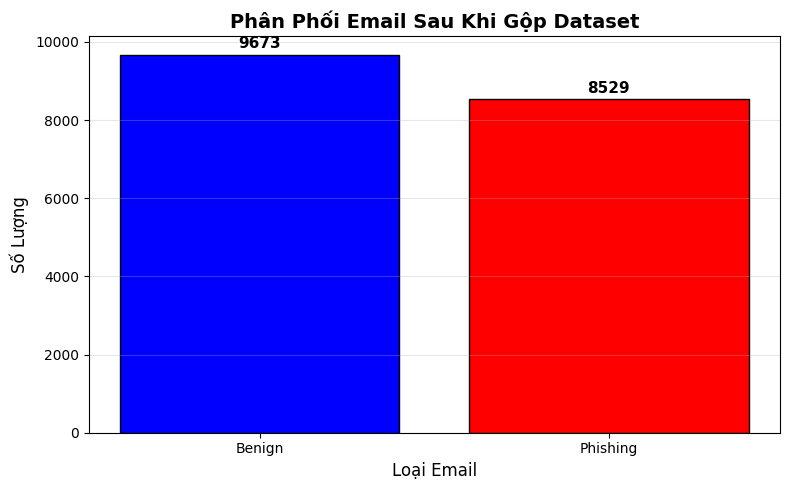

Hoàn tất tiền xử lý
✓ File cuối cùng: ./data/processed/processed_combined.csv
✓ Tổng số samples: 18202
✓ Sẵn sàng cho bước tiếp theo: analyze_and_imbalance_processing.ipynb


In [30]:
# Visualization phân phối dữ liệu
import matplotlib.pyplot as plt

counts = combined_df['label'].value_counts().values
categories = ['Benign', 'Phishing']

plt.figure(figsize=(8, 5))
plt.bar(categories, counts, color=['blue', 'red'], edgecolor='black')
plt.xlabel('Loại Email', fontsize=12)
plt.ylabel('Số Lượng', fontsize=12)
plt.title('Phân Phối Email Sau Khi Gộp Dataset', fontsize=14, fontweight='bold')

# Thêm số lượng lên trên mỗi cột
for i, count in enumerate(counts):
    plt.text(i, count + 100, str(count), ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("=" * 70)
print("Hoàn tất tiền xử lý")
print("=" * 70)
print(f"✓ File cuối cùng: {output_file}")
print(f"✓ Tổng số samples: {len(combined_df)}")
print(f"✓ Sẵn sàng cho bước tiếp theo: analyze_and_imbalance_processing.ipynb")
